In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor 
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32*7*7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = MNIST(root='.', train=True, transform=ToTensor())
test_dataset = MNIST(root='.', train=False, transform=ToTensor())

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10



Epoch: 1, Loss: 0.25
Epoch: 2, Loss: 0.07
Epoch: 3, Loss: 0.05
Epoch: 4, Loss: 0.04
Epoch: 5, Loss: 0.04
Epoch: 6, Loss: 0.03
Epoch: 7, Loss: 0.03
Epoch: 8, Loss: 0.02
Epoch: 9, Loss: 0.02
Epoch: 10, Loss: 0.02


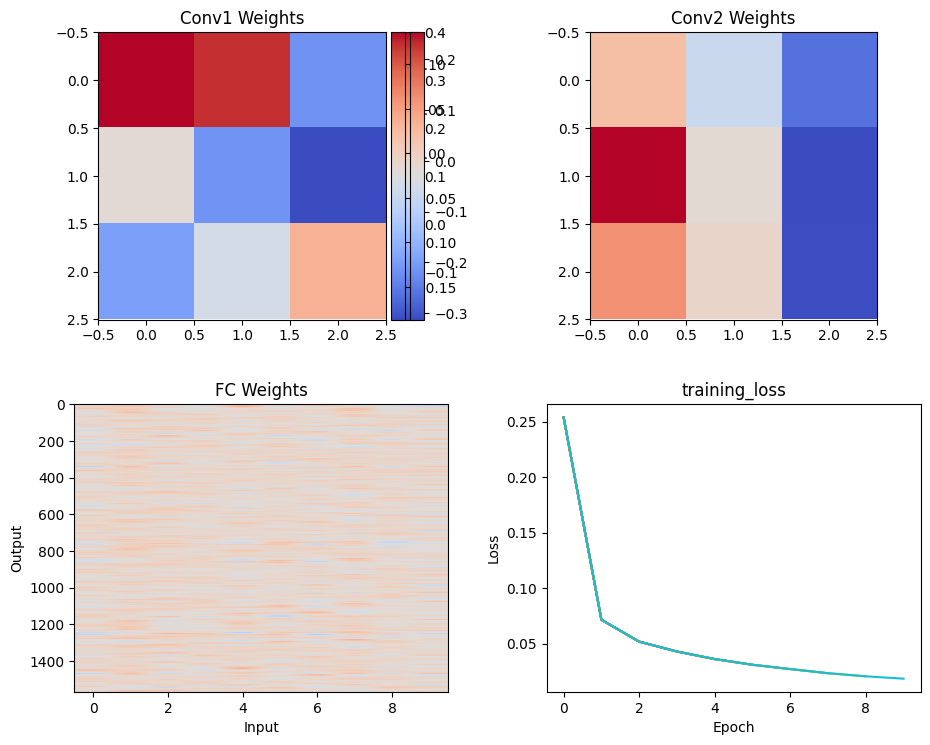

In [5]:
# 시각화를 위한 그리드 설정
fig, axs = plt.subplots(2,2,figsize=(10,8))
fig.tight_layout(pad=4.0)
axs = axs.flatten()
epoch_losses = []

for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    
    for imgs,labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        output = model(imgs)
        loss = criterion(output,labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    epoch_losses.append(epoch_loss)
    
    print(f'Epoch: {epoch+1}, Loss: {epoch_loss:.2f}')
    
    # 첫번째 합성곱 레이어의 가중치 시각화
    if epoch == 0:
        weight = model.conv1.weight.detach().cpu().numpy()
        axs[0].imshow(weight[0, 0], cmap='coolwarm')
        axs[0].set_title('Conv1 Weights')
        devider = make_axes_locatable(axs[0])
        cax = devider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(axs[0].imshow(weight[0,0], cmap='coolwarm'), cax=cax)
        
        weight = model.conv2.weight.detach().cpu().numpy()
        axs[1].imshow(weight[0, 0], cmap='coolwarm')
        axs[1].set_title('Conv2 Weights')
        devider = make_axes_locatable(axs[0])
        cax = devider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(axs[1].imshow(weight[0,0], cmap='coolwarm'), cax=cax)
        
    if epoch == 0 :
        weights = model.fc.weight.detach().cpu().numpy()
        axs[2].imshow(weights.T, cmap='coolwarm', aspect='auto')
        axs[2].set_title('FC Weights')
        axs[2].set_xlabel('Input')
        axs[2].set_ylabel('Output')
        divider = make_axes_locatable(axs[2])
        cax = devider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(axs[2].imshow(weights.T, cmap='coolwarm', aspect='auto'), cax=cax)
        
    axs[3].plot(range(epoch+1), epoch_losses)
    axs[3].set_title('training_loss')
    axs[3].set_xlabel('Epoch')
    axs[3].set_ylabel('Loss')
    
plt.show()

In [6]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    accuracy = 100 * correct / total
    print(f'test accuracy: {accuracy:.2f}')

test accuracy: 98.60
